In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
import PIL

# Домашнее задание №3

Решенный ноутбук нужно загрузить в [форму](http://bit.ly/dafe_hw)  
Дедлайн: __22.05.2019__

## Загрузка данных (5%)

In [186]:
lfw_people = datasets.fetch_lfw_people(
    min_faces_per_person=50, 
    resize=0.4)

Выведите:
- кол-во объектов
- Кол-во признаков
- кол-во классов
- посмотрите, сколько изображений соответствет каждому классу
- Отрисуйте изображения для случайных семплов с подписями имен класса 

кол-во объектов 1560
Кол-во признаков 1850
кол-во классов 12
{0: 77, 1: 236, 2: 121, 3: 530, 4: 109, 5: 71, 6: 52, 7: 55, 8: 53, 9: 60, 10: 52, 11: 144}


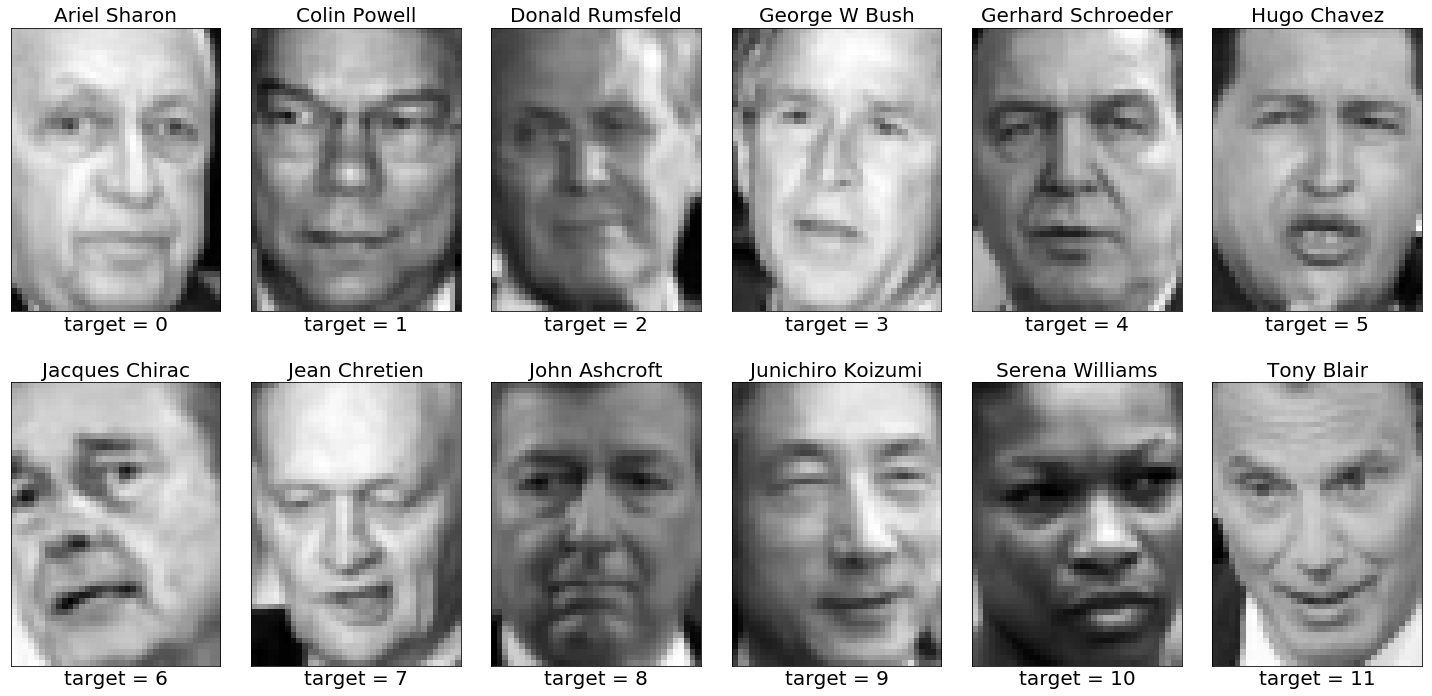

In [4]:
# Ваш код здесь
print('кол-во объектов', lfw_people.data.shape[0])
print('Кол-во признаков', lfw_people.data.shape[1])
num_classes = len(set(lfw_people.target))
print('кол-во классов', num_classes)
unique, counts = np.unique(lfw_people.target, return_counts=True)
print(dict(zip(unique, counts)))

pic_to_idx = {idx:i for i, idx in enumerate(lfw_people.target)}

fig, ax = plt.subplots(nrows = 2, ncols = 6, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(num_classes):
    ax[i].imshow(lfw_people.images[pic_to_idx.get(i)], cmap='gray')
    ax[i].set_title(lfw_people.target_names[i], fontsize=20)
    ax[i].set_xlabel('target = {}'.format(i), fontsize=20)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.tight_layout()
plt.show()

## Пора учить нейронки! (5%) 

In [5]:
from keras.models import Sequential 
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D, Dropout 
from keras.utils import np_utils
from keras.optimizers import Adam

Using TensorFlow backend.


In [6]:
# Конечно мы сначала должны нормировать и центрировать данные: 
mean, std = lfw_people.data.mean(), lfw_people.data.std()
x = (lfw_people.data - mean) / std
y = lfw_people.target

# используйте lfw_people.target и lfw_people.images

In [7]:
def indices_to_one_hot(data, nb_classes):
    """one-hot-encoding"""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

y_ohe = indices_to_one_hot(y, num_classes)

In [8]:
# Разделим данные на трейн/валидацию/тест: 
x_train, x_test, y_train_cat, y_test_cat = train_test_split(x, y_ohe, 
                                                            train_size=0.6, 
                                                            test_size=0.4, 
                                                            random_state=42)
x_val, x_test, y_val_cat, y_test_cat = train_test_split(x_test, y_test_cat, 
                                                        train_size=0.5, 
                                                        test_size=0.5, 
                                                        random_state=42)

# Cделайте one-hot-encoding для целевой переменной

## Fully connected neural network (20%)
Создадим нашу первую модель, будем использовать полносвязную нейронную сеть 
- Первый слой (входной): 64 нейрона, функция активации ReLU
- Скрытый слой: 32 нейрона, функция активации ReLU
- Чтобы наша сеть не переобучалась, после каждого полно-связного используйте слой Dropout с параметром rate = 0.4
- Выходной слой: на ваше усмотрение :) 

Будем обучать с помощью Adam на 100 эпохах,  размер сэмпла для минибатча: 10

Учимся на train, валидируем на val

In [13]:
input_shape = x_test[0, :].shape
epochs = 100
batch_size = 10
steps = 300

### Generator (threads)

In [14]:
import threading

class threadsafe_iter:
    """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)
        
def threadsafe_generator(f):
    """
    A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

In [15]:
@threadsafe_generator
def make_image_gen_cat(in_df, batch_size=batch_size):
    out_map = []
    out_class = []
    x, y = in_df
    indexes = np.random.randint(0, x.shape[0], x.shape[0])
    while True:
        for index in indexes:
            out_map += [x[index]]
            out_class += [y[index]]
            if len(out_map) >= batch_size:
                out_map = np.array(out_map)
                out_class = np.array(out_class)
                out_map = out_map.reshape(out_map.shape[0], input_shape[0])
                yield np.stack(out_map, 0), out_class
                out_map = []
                out_class = []

In [16]:
valid_x, valid_y = next(make_image_gen_cat((x_test, y_test_cat)))
print(valid_x.shape, valid_y.shape)

(10, 1850) (10, 12)


In [17]:
model = Sequential()
model.add(Dense(64, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = Adam()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                118464    
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                396       
__________

In [21]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path='easy_weights.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=7)



callbacks_list = [checkpoint, reduceLROnPlat, early]

In [22]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
gen_train_cat = make_image_gen_cat((x_train, y_train_cat))
gen_valid_cat = make_image_gen_cat((x_val, y_val_cat))

history = model.fit_generator(gen_train_cat,
                              steps_per_epoch=steps,
                              validation_data=gen_valid_cat,
                              validation_steps=100,
                              epochs=epochs,
                              callbacks=callbacks_list,
                              workers=16,
                              verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
300/300 [==============================] - 1s 3ms/step - loss: 2.1034 - acc: 0.3240 - val_loss: 1.8048 - val_acc: 0.4640

Epoch 00001: val_acc improved from -inf to 0.46400, saving model to easy_weights.h5
Epoch 2/100
300/300 [==============================] - 1s 2ms/step - loss: 1.6078 - acc: 0.4680 - val_loss: 1.6118 - val_acc: 0.5200

Epoch 00002: val_acc improved from 0.46400 to 0.52000, saving model to easy_weights.h5
Epoch 3/100
300/300 [==============================] - 1s 2ms/step - loss: 1.3195 - acc: 0.5597 - val_loss: 1.6131 - val_acc: 0.5800

Epoch 00003: val_acc improved from 0.52000 to 0.58000, saving model to easy_weights.h5
Epoch 4/100
300/300 [==============================] - 1s 2ms/step - loss: 1.1028 - acc: 0.6293 - val_loss: 1.4924 - val_acc: 0.5940

Epoch 00004: val_acc improved from 0.58000 to 0.59400, saving model to easy_weights.h5
Epoch 5/100
300/300 [==============================] - 1s 2ms/step - lo

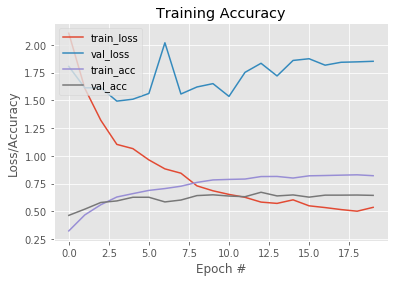

In [24]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
N = len(history.epoch)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plot the trainingaccuracy
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

Постройте confusion_matrix (используйте sklearn) на тестовой выборке (test) и посчитайте долю правильных ответов(test)

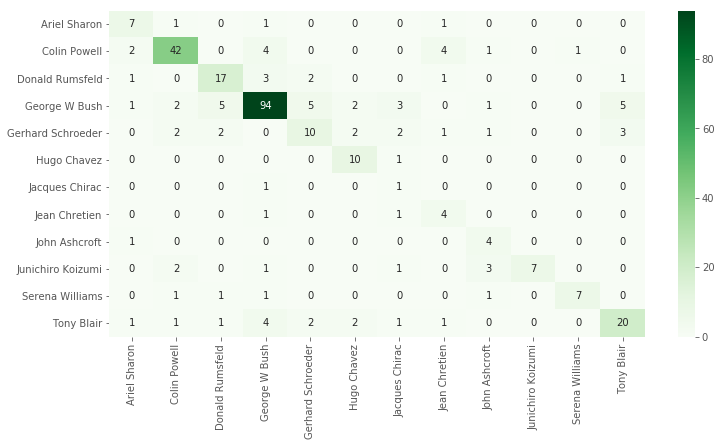

In [25]:
y_pred = model.predict(x_test).argmax(axis=1)
y_true = y_test_cat.argmax(axis=1)
confusionmatrix = confusion_matrix(y_pred, y_true)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()

Оцените, кого с кем вы чаще всего путаете? Почему одних людей наша сеть путает с другими чаще?

__Ответ:__

Вспомним, что в нашей задачи классы, не сбалансированы, какая получится доля правильных ответов, если мы всегда будем предсказывать константнам значением: George W Bush

In [26]:
y_Bush = np.ones(y_true.shape) * np.where(lfw_people.target_names == 'George W Bush')[0][0]
accuracy_Bush = accuracy_score(y_Bush, y_true)
accuracy = accuracy_score(y_pred, y_true)

print('Доля верных ответов на всем тесте: %.2f' % accuracy)
print('Доля верных ответов на константе George W Bush: %.2f' % accuracy_Bush)

Доля верных ответов на всем тесте: 0.71
Доля верных ответов на константе George W Bush: 0.35


## Это же картинки! Попробуем Convolution neural network (30%)

- Используйте два сверточных слоя (по 16 нейронов с функцией активации ReLu, padding='same')
- Затем слой MaxPooling'a с размерром 2х2
- Затем полносвязные слои: 32 нейрона и 16 нейронов
- Выходной слой как раньше 

Помните о требованиях свертки к размерности входных данных и используйте `.reshape`

In [29]:
input_shape = lfw_people.images.shape[1:]
epochs = 100
batch_size = 10
steps = 100

In [30]:
x = lfw_people.images
x_train, x_test, y_train_cat, y_test_cat = train_test_split(x, y_ohe, 
                                                            train_size=0.6, 
                                                            test_size=0.4, 
                                                            random_state=42)
x_val, x_test, y_val_cat, y_test_cat = train_test_split(x_test, y_test_cat, 
                                                        train_size=0.5, 
                                                        test_size=0.5, 
                                                        random_state=42)

In [31]:
@threadsafe_generator
def make_image_gen_cat_conv(in_df, batch_size=batch_size):
    out_map = []
    out_class = []
    x, y = in_df
    indexes = np.random.randint(0, x.shape[0], x.shape[0])
    while True:
        for index in indexes:
            out_map += [x[index]/255.]
            out_class += [y[index]]
            if len(out_map) >= batch_size:
                out_map = np.array(out_map)
                out_class = np.array(out_class)
                out_map = out_map.reshape(out_map.shape[0], input_shape[0], input_shape[1], 1)
                yield np.stack(out_map, 0), out_class
                out_map = []
                out_class = []

In [32]:
valid_x, valid_y = next(make_image_gen_cat_conv((x_test, y_test_cat)))
print(valid_x.shape, valid_y.shape)

(10, 50, 37, 1) (10, 12)


In [34]:
class small_conv_net:
    @staticmethod
    def build(classes, finalAct="softmax"):
        model = Sequential()
        
        model.add(Conv2D(16, (3, 3), padding="same", 
                 input_shape=(input_shape[0], input_shape[1], 1)))
        model.add(Activation('relu'))
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        model.add(Flatten())
        model.add(Dense(32))
        model.add(Activation('relu'))
        model.add(Dense(16))
        model.add(Activation('relu'))
        model.add(Dropout(0.4))
        
        model.add(Dense(classes))
        model.add(Activation(finalAct))

        return model

model_conv = small_conv_net.build(classes=num_classes, finalAct="softmax")
opt = Adam(lr=1e-3)

In [35]:
model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 50, 37, 16)        160       
_________________________________________________________________
activation_9 (Activation)    (None, 50, 37, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 37, 16)        2320      
_________________________________________________________________
activation_10 (Activation)   (None, 50, 37, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 18, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 25, 18, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7200)              0         
__________

In [36]:
weight_path='easy_conv.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=7)



callbacks_list = [checkpoint, reduceLROnPlat, early]

In [37]:
model_conv.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
reset_weights(model_conv)

In [38]:
gen_train_cat = make_image_gen_cat_conv((x_train, y_train_cat))
gen_valid_cat = make_image_gen_cat_conv((x_val, y_val_cat))

history = model_conv.fit_generator(gen_train_cat,
                                   steps_per_epoch=steps,
                                   validation_data=gen_valid_cat,
                                   validation_steps=20,
                                   epochs=epochs,
                                   callbacks=callbacks_list,
                                   workers=16,
                                   verbose=1)

Epoch 1/100
100/100 [==============================] - 2s 16ms/step - loss: 2.3477 - acc: 0.1910 - val_loss: 2.1515 - val_acc: 0.3450

Epoch 00001: val_acc improved from -inf to 0.34500, saving model to easy_conv.h5
Epoch 2/100
100/100 [==============================] - 1s 12ms/step - loss: 2.2904 - acc: 0.2850 - val_loss: 2.2341 - val_acc: 0.3650

Epoch 00002: val_acc improved from 0.34500 to 0.36500, saving model to easy_conv.h5
Epoch 3/100
100/100 [==============================] - 1s 13ms/step - loss: 2.1973 - acc: 0.3130 - val_loss: 2.0337 - val_acc: 0.3600

Epoch 00003: val_acc did not improve from 0.36500
Epoch 4/100
100/100 [==============================] - 1s 13ms/step - loss: 2.0430 - acc: 0.3390 - val_loss: 1.9807 - val_acc: 0.3400

Epoch 00004: val_acc did not improve from 0.36500
Epoch 5/100
100/100 [==============================] - 1s 13ms/step - loss: 1.8330 - acc: 0.4140 - val_loss: 1.7168 - val_acc: 0.4450

Epoch 00005: val_acc improved from 0.36500 to 0.44500, savin

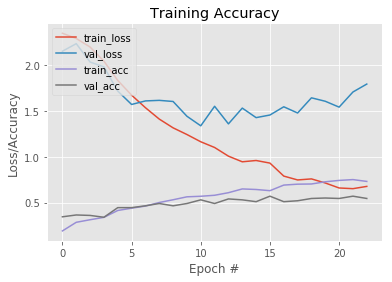

In [39]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
N = len(history.epoch)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plot the trainingaccuracy
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

Постройте confusion_matrix (используйте sklearn) на тестовой выборке (test) и посчитайте долю правильных ответов(test)

Доля верных ответов на всем тесте: 0.54


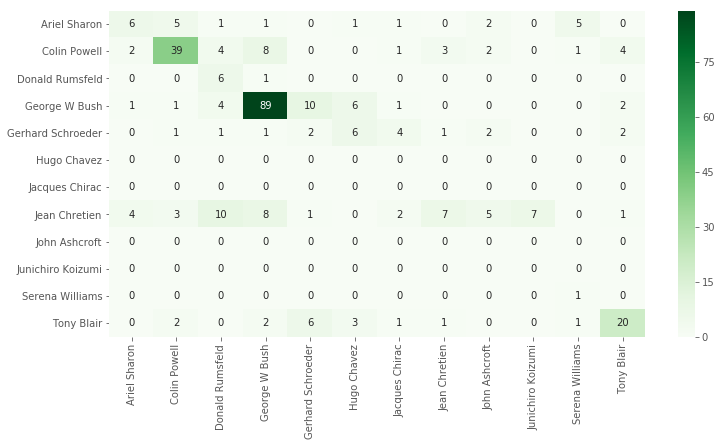

In [40]:
y_pred = model_conv.predict(x_test.reshape(x_test.shape[0], input_shape[0], input_shape[1], 1)).argmax(axis=1)
y_true = y_test_cat.argmax(axis=1)
confusionmatrix = confusion_matrix(y_pred, y_true)

accuracy = accuracy_score(y_pred, y_true)
print('Доля верных ответов на всем тесте: %.2f' % accuracy)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()

Кажется, что стало лучше, но постройте график зависимости доли правильных ответов от эпохи на обучении и валидации. Какие выводы можно сделать?  

### Ваши ответы здесь

## Aугментация дынных (40%)
Вспомним, что для борьбы с переобучением, нам может помочь Aугментация, для этого мы будем использовать стандартные возможности Keras. Загляните в [доку](https://keras.io/preprocessing/image/) или в эту [статью](https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085) 

Вы можете использовать любые аугментации

In [583]:
from keras.preprocessing.image import ImageDataGenerator

dg_args = dict(featurewise_center = False, 
               samplewise_center = False,
               horizontal_flip=True,
               rotation_range = 15, 
               brightness_range=[0.9, 1.1],
               shear_range = 0.01,
               width_shift_range = 0.1, 
               height_shift_range = 0.1)


image_gen = ImageDataGenerator(**dg_args)
@threadsafe_generator
def create_aug_gen(in_gen):
    for in_x, in_y in in_gen:
        g_x = image_gen.flow(255*in_x, 
                             batch_size=in_x.shape[0])

        yield next(g_x)/255., in_y

(3, 50, 37, 1) (3, 12)


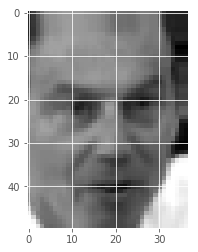

In [584]:
valid_x, valid_y = next(create_aug_gen(make_image_gen_cat_conv((x_test, y_test_cat))))
print(valid_x.shape, valid_y.shape)

test = valid_x[0,:,:,0]
plt.imshow(test, cmap='gray')

In [99]:
weight_path='easy_conv.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=7)



callbacks_list = [checkpoint, reduceLROnPlat, early]

In [100]:
model_conv = small_conv_net.build(classes=num_classes, finalAct="softmax")
opt = Adam(lr=1e-1)
model_conv.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
reset_weights(model_conv)

In [101]:
aug_gen = create_aug_gen(make_image_gen_cat_conv((x_train, y_train_cat)))
gen_valid_cat = make_image_gen_cat_conv((x_val, y_val_cat))

history = model_conv.fit_generator(aug_gen,
                                   steps_per_epoch=steps,
                                   validation_data=create_aug_gen(gen_valid_cat),
                                   validation_steps=50,
                                   epochs=epochs,
                                   callbacks=callbacks_list,
                                   workers=16,
                                   verbose=1)

Epoch 1/100
100/100 [==============================] - 2s 20ms/step - loss: 12.3598 - acc: 0.2240 - val_loss: 9.5741 - val_acc: 0.4060

Epoch 00001: val_acc improved from -inf to 0.40600, saving model to easy_conv.h5
Epoch 2/100
100/100 [==============================] - 1s 14ms/step - loss: 12.6205 - acc: 0.2170 - val_loss: 10.0899 - val_acc: 0.3740

Epoch 00002: val_acc did not improve from 0.40600
Epoch 3/100
100/100 [==============================] - 1s 15ms/step - loss: 12.4432 - acc: 0.2280 - val_loss: 9.4774 - val_acc: 0.4120

Epoch 00003: val_acc improved from 0.40600 to 0.41200, saving model to easy_conv.h5
Epoch 4/100
100/100 [==============================] - 1s 15ms/step - loss: 12.4593 - acc: 0.2270 - val_loss: 10.0255 - val_acc: 0.3780

Epoch 00004: val_acc did not improve from 0.41200
Epoch 5/100
100/100 [==============================] - 2s 15ms/step - loss: 12.5721 - acc: 0.2200 - val_loss: 9.9287 - val_acc: 0.3840

Epoch 00005: val_acc did not improve from 0.41200
Epo

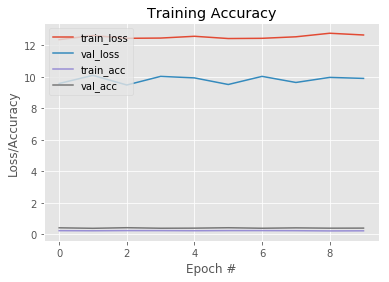

In [102]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
N = len(history.epoch)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plot the trainingaccuracy
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

Доля верных ответов на всем тесте: 0.35


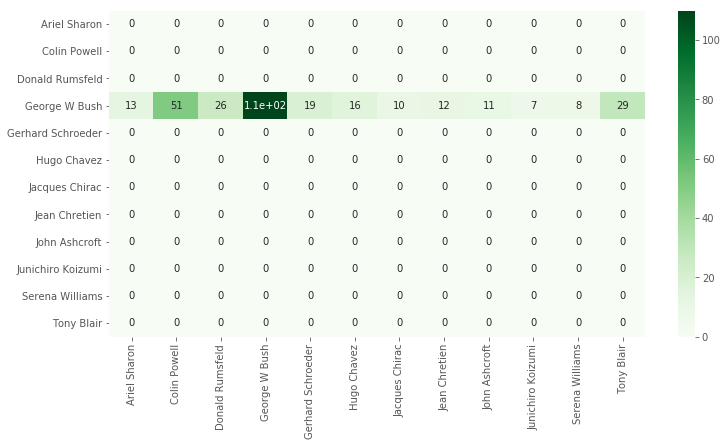

In [103]:
y_pred = model_conv.predict(x_test.reshape(x_test.shape[0], input_shape[0], input_shape[1], 1)).argmax(axis=1)
y_true = y_test_cat.argmax(axis=1)
confusionmatrix = confusion_matrix(y_pred, y_true)

accuracy = accuracy_score(y_pred, y_true)
print('Доля верных ответов на всем тесте: %.2f' % accuracy)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()

Посмотрите долю правильных ответов на тестовой выборке и постройте график зависимости от эпох для обучения и валидации
Ответьте на вопросы и объясните свой ответ: 
- Удалось ли Вам победить переобучение? 
- Будет ли полезна аугментация horizontal_flip?

### Ваши ответы здесь

## Дополнительное задание (дополнительные +30%) 
Обучите такую нейронную сеть, чтобы на тестовой выборке достичь доли правильных ответов больше 92%

In [111]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.utils import np_utils

In [346]:
lfw_people = datasets.fetch_lfw_people(
    min_faces_per_person=50, 
    resize=0.4)

data = [[d] for d in lfw_people.images]

df = pd.DataFrame(data, columns=['Image'])
df['Target'] = lfw_people.target
mapping_type = {i:name for i, name in enumerate(lfw_people.target_names)}
df['Name'] = df.Target.replace({'Target':mapping_type}) 
df = df.replace({'Name':mapping_type})
df.head()

,Image,Target,Name
0,"[[83.0, 91.666664, 112.0, 101.666664, 92.0, 11...",11,Tony Blair
1,"[[38.666668, 69.666664, 84.666664, 91.0, 97.0,...",4,Gerhard Schroeder
2,"[[82.666664, 58.0, 59.0, 66.333336, 71.666664,...",2,Donald Rumsfeld
3,"[[141.66667, 139.33333, 112.0, 91.0, 96.666664...",3,George W Bush
4,"[[89.666664, 96.666664, 90.0, 95.0, 142.0, 163...",3,George W Bush


<Figure size 432x216 with 0 Axes>

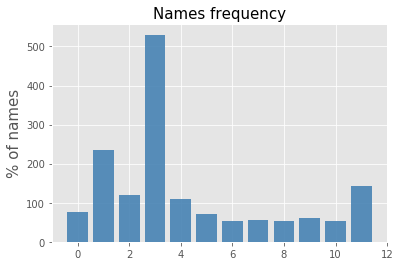

In [347]:
import matplotlib.pyplot as plt

uni_names = np.unique(df.Target, return_counts=True)

plt.figure(figsize=(6,3))
fig, ax = plt.subplots()
ax.bar(uni_names[0], uni_names[1],
            color='steelblue', align='center', alpha=0.9)
ax.set_title("Names frequency", fontsize=15)
ax.set_ylabel("% of names", fontsize=15)
plt.show();

In [348]:
np.random.seed(42)

remove_n = 300
drop_indices = np.random.choice(df.Target[df.Target == 3].index, remove_n, replace=False)
df_subset = df.drop(drop_indices)

In [349]:
input_shape = lfw_people.images.shape[1:]
epochs = 200
BATCH = 20
steps = 100

In [351]:
x = lfw_people.images
x_train, x_test, y_train_cat, y_test_cat = train_test_split(df_subset.Image.values, 
                                                            df_subset.Target.values, 
                                                            train_size=0.6, 
                                                            test_size=0.4, 
                                                            random_state=42)
x_val, x_test, y_val_cat, y_test_cat = train_test_split(x_test, y_test_cat, 
                                                        train_size=0.5, 
                                                        test_size=0.5, 
                                                        random_state=42)

In [436]:
@threadsafe_generator
def make_image_gen_cat_conv(in_df, batch_size=3, classes=12):
    out_map = []
    out_class = []
    x, y = in_df
    indexes = np.random.randint(0, x.shape[0], x.shape[0])
    while True:
        for index in indexes:
            out_map += [x[index]/255.]
            out_class += [indices_to_one_hot(y[index], classes)]
            if len(out_map) >= batch_size:
                out_map = np.array(out_map)
                out_class = np.array(out_class)
                out_map = out_map.reshape(out_map.shape[0], input_shape[0], input_shape[1], 1)
                yield np.stack(out_map, 0), out_class.reshape((batch_size, classes))
                out_map = []
                out_class = []

(3, 50, 37, 1) (3, 12)


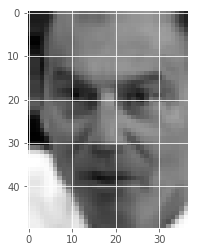

In [442]:
valid_x, valid_y = next(create_aug_gen(make_image_gen_cat_conv((x_test, y_test_cat))))
print(valid_x.shape, valid_y.shape)

test = valid_x[0,:,:,0]
plt.imshow(test, cmap='gray')
plt.show()

In [443]:
class small_vgg:
    @staticmethod
    def build(classes, finalAct="softmax"):
        model = Sequential()
        
        model.add(Conv2D(16, (5, 5), padding="same", 
                 input_shape=(input_shape[0], input_shape[1], 1)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(16, (5, 5), padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))
       
#         model.add(Conv2D(32, (3, 3), padding="same"))
#         model.add(Activation('relu'))
#         model.add(Conv2D(32, (3, 3), padding="same"))
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.4))
        
#         model.add(Conv2D(32, (3, 3), padding="same"))
#         model.add(Activation('relu'))
#         model.add(Conv2D(32, (3, 3), padding="same"))
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.4))

        model.add(Flatten())
        model.add(Dense(32))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dense(16))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        
        model.add(Dense(classes))
        model.add(Activation(finalAct))

        # return the constructed network architecture
        return model

model_conv = small_vgg.build(classes=num_classes, finalAct="softmax")
opt = Adam(lr=1e-3)

In [444]:
model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 50, 37, 16)        416       
_________________________________________________________________
activation_69 (Activation)   (None, 50, 37, 16)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 50, 37, 16)        64        
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 50, 37, 16)        6416      
_________________________________________________________________
activation_70 (Activation)   (None, 50, 37, 16)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 50, 37, 16)        64        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 18, 16)        0         
__________

In [445]:
weight_path='easy_conv.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=7)



callbacks_list = [checkpoint, reduceLROnPlat, early]

In [446]:
model_conv.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
reset_weights(model_conv)

In [ ]:
aug_gen_cat = create_aug_gen(make_image_gen_cat_conv((x_train, y_train_cat), batch_size=BATCH))
valid_cat = make_image_gen_cat_conv((x_val, y_val_cat), batch_size=BATCH)

gen_cat = make_image_gen_cat_conv((x_val, y_val_cat), batch_size=BATCH)

history = model_conv.fit_generator(aug_gen_cat,
                                   steps_per_epoch=steps,
                                   validation_data=valid_cat,
                                   validation_steps=50,
                                   epochs=epochs,
                                   callbacks=callbacks_list,
                                   workers=16,
                                   verbose=1)

Epoch 1/200
100/100 [==============================] - 8s 84ms/step - loss: 2.4024 - acc: 0.1905 - val_loss: 2.1611 - val_acc: 0.3340

Epoch 00001: val_acc did not improve from 0.33800
Epoch 2/200
 46/100 [============>.................] - ETA: 3s - loss: 2.3738 - acc: 0.1848

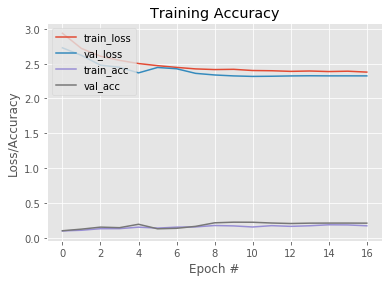

In [448]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
N = len(history.epoch)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plot the trainingaccuracy
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

Доля верных ответов на всем тесте: 0.07


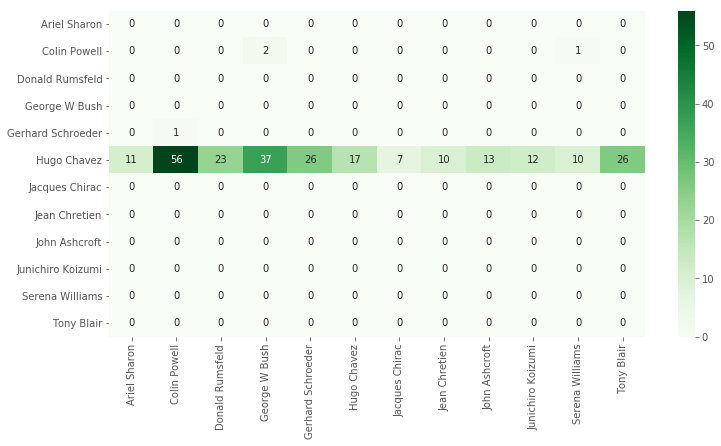

In [478]:
y_pred = model_conv.predict(np.array([ex for ex in x_test]).reshape(x_test.shape[0], 
                                                                    input_shape[0], 
                                                                    input_shape[1], 1)).argmax(axis=1)
y_true = y_test_cat
confusionmatrix = confusion_matrix(y_pred, y_true)

accuracy = accuracy_score(y_pred, y_true)
print('Доля верных ответов на всем тесте: %.2f' % accuracy)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()